# Unsupervised Learning Final Project

## Introduction

In this unsupervised learning final project, we are going to explore a medical dataset. The dataset contains 5000 entries on patient medical transcriptions. In dataset, there are transcriptions that describe the medical appointment. In addition, there is a column that classifies what kind of medical specialty the appointment falls into. Our goal for this project is to see if we can classify these medical specialties based on the appointment transcription. The process will include:
1. Exploring the data
2. Cleaning the data
3. Vectorizing the data
4. Build a non-negative matrix factorization model
5. Build an Agglomerative Clustering Model
6. Make conclusions based on the results.

First we'll import some of the important libraries needed for exploratory data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

The data used for this project is a dataset off of Kaggle. The title is called Medical Transcriptions uploaded by Tara Boyle. The link to the data is given here: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions . 

Now let us import the dataset and take a look at our data. The dataset was taken off  The dataset contains a short description, the medical specialty of the appointment, a sample name, the transcription, and any keywords related to the description. In total, there are 5000 rows of data with some transcriptions and keywords missing.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/kech3776/MedicalTranscript/main/mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


Next, we will look at all of the unique medical specialties in the dataset. There are 40 unique medical specialties in this dataset.

In [5]:
print(df['medical_specialty'].unique())
print(len(df['medical_specialty'].unique()))

[' Allergy / Immunology' ' Bariatrics' ' Cardiovascular / Pulmonary'
 ' Neurology' ' Dentistry' ' Urology' ' General Medicine' ' Surgery'
 ' Speech - Language' ' SOAP / Chart / Progress Notes' ' Sleep Medicine'
 ' Rheumatology' ' Radiology' ' Psychiatry / Psychology' ' Podiatry'
 ' Physical Medicine - Rehab' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Office Notes' ' Obstetrics / Gynecology'
 ' Neurosurgery' ' Nephrology' ' Letters' ' Lab Medicine - Pathology'
 ' IME-QME-Work Comp etc.' ' Hospice - Palliative Care'
 ' Hematology - Oncology' ' Gastroenterology' ' ENT - Otolaryngology'
 ' Endocrinology' ' Emergency Room Reports' ' Discharge Summary'
 ' Diets and Nutritions' ' Dermatology' ' Cosmetic / Plastic Surgery'
 ' Consult - History and Phy.' ' Chiropractic' ' Autopsy']
40


Forty medical specialties is a ton on specialties to classify. Furthermore, many of the specialties don't have a ton of entries. For this project, we will take all of the medical specialties that have 200 or more entries which is the top 8 most frequent specialties. Below, there a list of the top 8 and a histogram to get a visualization of the frequencies of the specialties.

In [6]:
specialties = df['medical_specialty'].value_counts().to_frame()
specialties = specialties.reset_index()
specialties.columns = ['medical_specialty', 'frequency']
specialties = specialties.head(8)
specialties

,medical_specialty,frequency
0,Surgery,1103
1,Consult - History and Phy.,516
2,Cardiovascular / Pulmonary,372
3,Orthopedic,355
4,Radiology,273
5,General Medicine,259
6,Gastroenterology,230
7,Neurology,223


<AxesSubplot:xlabel='frequency', ylabel='medical_specialty'>

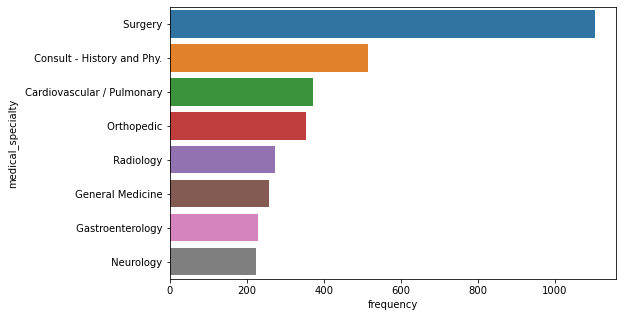

In [7]:
fig, axs = plt.subplots(figsize = (8,5))
sns.barplot(data = specialties, y = 'medical_specialty', x = 'frequency')

After keeping the top 8 most frequent specialties, we now have 3331 entries. However, remember that there are some transcriptions that are blank. We will also remove any blank entries. After removing the blank entries, we now have 3309 transcriptions.

In [8]:
specialties['frequency'].sum()

3331

In [9]:
reduced_df = pd.merge(df, specialties, on ='medical_specialty', how = 'inner' )
reduced_df.shape

(3331, 7)

In [10]:
reduced_df = reduced_df[['medical_specialty', 'transcription', 'keywords']].copy()
transcription_df = reduced_df.dropna(subset = ['transcription'])
transcription_df = transcription_df.reset_index(drop = True)
print(transcription_df.shape)
print(reduced_df.shape)

(3309, 3)
(3331, 3)


We have now seen some of the preliminary data. Let's start to clean that data into something we can use. Below, we have a method that cleans the text data into something that we can use. For this process, we will be using the nltk library.
The process goes:
1. Tokenize all of the text
2. Remove any of the punctuation.
3. Remove any stop words such as "to" and "or"
4. Stemming the words still present to reduce the number of similar words i.e. fish, fishing, fished

In [11]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def clean_data(df, column_name):
    df_set = []
    df_set_length = []
    string_set = []
    for i in range(len(df)):
        tokens = word_tokenize(df[column_name][i])
        table = str.maketrans('','',string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        porter = PorterStemmer()
        stemmed = [porter.stem(term) for term in words ]
        df_set.append(stemmed)
        df_set_length.append(len(stemmed))
        string_set.append(' '.join(stemmed))
    df['Tokenized'] = df_set
    df['SetLength'] = df_set_length
    df['String Set'] = string_set
    return df

Here we can see the cleaned data. The 'Tokenized' column shows what the article in the text looks like once tokenized. The 'SetLength' is how long the article is after the text processing. The 'String Set' column will be the data used to transform the text into tf-idf representation.

In [12]:
clean_transcript_data = clean_data(transcription_df, 'transcription')
clean_transcript_data.head()

,medical_specialty,transcription,keywords,Tokenized,SetLength,String Set
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...","[mmode, left, atrial, enlarg, left, atrial, di...",45,mmode left atrial enlarg left atrial diamet no...
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...","[the, left, ventricular, caviti, size, wall, t...",161,the left ventricular caviti size wall thick ap...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","cardiovascular / pulmonary, 2-d echocardiogram...","[echocardiogram, multipl, view, heart, great, ...",78,echocardiogram multipl view heart great vessel...
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","cardiovascular / pulmonary, ejection fraction,...","[descript, normal, cardiac, chamber, normal, l...",46,descript normal cardiac chamber normal left ve...
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...","[mild, aortic, stenosi, wide, calcifi, minim, ...",55,mild aortic stenosi wide calcifi minim mild le...


Below are a couple more visuals of the data. The transcriptions have a mean length of 295 words with a standard deviation of 184 words. For the histogram, the word count skews to the right.

In [13]:
clean_transcript_data['SetLength'].describe()

count    3309.000000
mean      295.878211
std       184.524694
min         1.000000
25%       161.000000
50%       264.000000
75%       392.000000
max      1417.000000
Name: SetLength, dtype: float64

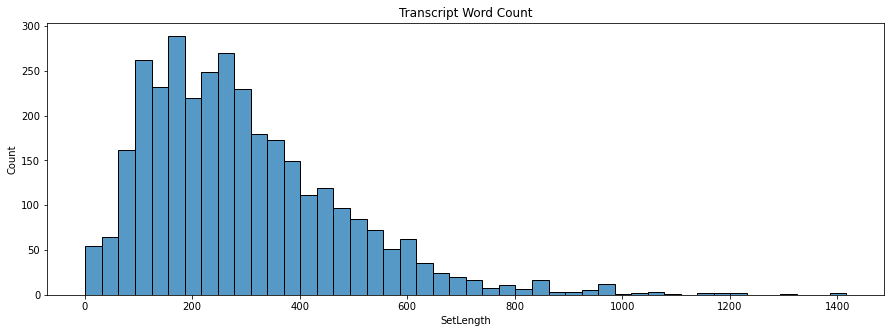

In [14]:
fig, axs = plt.subplots(figsize = (15,5))
sns.histplot(data = clean_transcript_data['SetLength'])
axs.title.set_text('Transcript Word Count')

The box plot shows the distribution of lengths between the specialties. It looks like radiology transcripts tend to have to lowest number of words. Orthopedic appointments tend to have longer transcripts compared to other specialties. Consults and surgery look to have the most outliers.

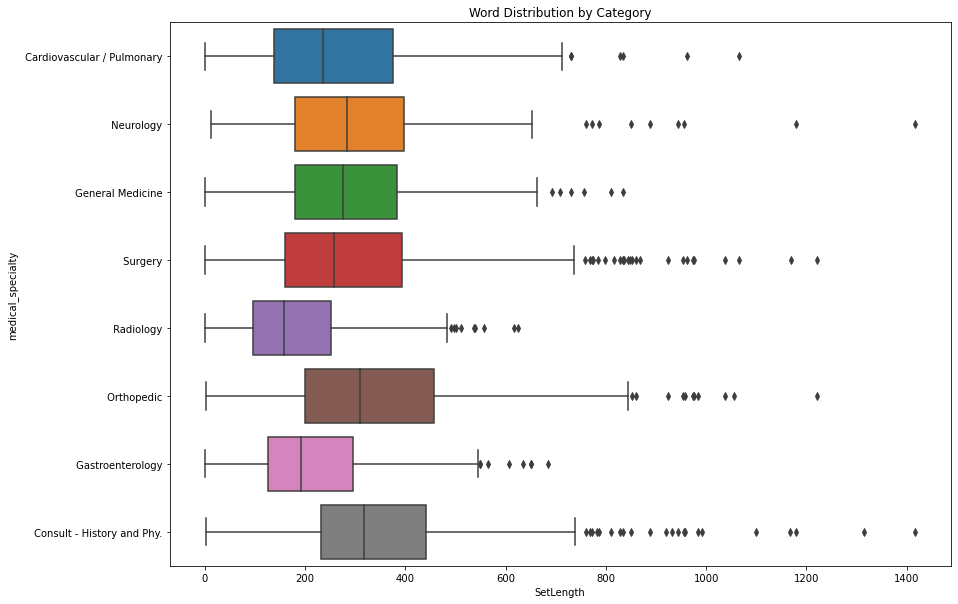

In [15]:
fig, axs = plt.subplots(figsize = (14,10))
sns.boxplot(data = clean_transcript_data, x = 'SetLength', y = 'medical_specialty')
axs.title.set_text('Word Distribution by Category')

## Building and Training Models

Now we transform the 'Set String' processed text data into a tf-idf matrix. First we split the data into training data and test data. Next, we call TfidVectorizer. I run a loop to have multiple vectorized matrices with different min_df. The min_df is the minimun frequency a word needs to appear in to be counted. I get a list of 4 transformed sparse matrices. For exmaple, the first transformed matrix is a 2647x4514 sparse matrix. This means that for the 2647 transcriptions in the training data, there are 4514 unique words that have been counted as relevant. Depending on the min_df, there will be fewer key words since the higher the min_df, the fewer the key words.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clean_transcript_data['String Set'], clean_transcript_data['medical_specialty'], test_size = 0.2, random_state = 15) 

min_df = [10,20,100,200]
X_vects = []
vectorizers = []
for i in min_df:
    vectorizer = TfidfVectorizer(min_df = i)
    X = vectorizer.fit_transform(X_train)
    X_vects.append(X)
    vectorizers.append(vectorizer)
X_vects

[<2647x4514 sparse matrix of type '<class 'numpy.float64'>'
 	with 426127 stored elements in Compressed Sparse Row format>,
 <2647x3154 sparse matrix of type '<class 'numpy.float64'>'
 	with 407616 stored elements in Compressed Sparse Row format>,
 <2647x1033 sparse matrix of type '<class 'numpy.float64'>'
 	with 313170 stored elements in Compressed Sparse Row format>,
 <2647x533 sparse matrix of type '<class 'numpy.float64'>'
 	with 242760 stored elements in Compressed Sparse Row format>]

### Non Negative Matrix Factorization

Next, we take that sparse matrix and create an NMF model to generate the feature and component matrices. The n_components is equal to 8 since there are 8 different medical specialties. I will also run a loop to tune the hyperparameters of init. There are 12 transformations total. 

In [24]:
from sklearn.decomposition import NMF
init = ['random', 'nndsvd', 'nndsvda']
nmf_transformations = []
nmf_models = []
for i in X_vects:
    for j in init:
        model = NMF(n_components = 8, random_state = 100, init = j)
        model.fit(i)
        nmf_features = model.transform(i)
        nmf_transformations.append(nmf_features)
        nmf_models.append(model)

C:\Anaconda\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Here I take the first one from the list as an example. The features matrix is 2647x8 meaning that of the 2647 transcriptions in the training set and each transcription is given 8 scores. Each score determines what medical specialty the model thinks the transcription is in with the highest score being the prediction. I have shown below the scores given to transcription 100. For that transcription it looks like the model thinks that the article belongs to category 7 with the highest score of 0.0855. The components matrix has a shape of 8x4514. The components matrix shows all of the words and how how related they are to each medical specialty.

In [25]:
nmf_transformations[0].shape

(2647, 8)

In [27]:
pd.DataFrame(nmf_transformations[0]).iloc[100]

0    0.002501
1    0.008306
2    0.000000
3    0.009642
4    0.067549
5    0.004271
6    0.012224
7    0.085512
Name: 100, dtype: float64

In [28]:
nmf_models[0].components_.shape

(8, 4514)

Here is what the components dataframe looks like as a dataframe. The column labels show the words and how much they influence the decision of each transciption to be put into each medical specialty. Below, I have shown the first 10 of 4514 words.

In [33]:
components_df = pd.DataFrame(nmf_models[0].components_, columns=vectorizers[0].get_feature_names_out()) 
components_df.iloc[:, :10]

,abc,abcd,abd,abdomen,abdomin,abduct,abductor,abductovalgu,abg,abil
0,0.018386,0.011250,0.002492,0.312621,0.193492,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.007653,0.000000,0.000000,0.000000,0.005274,0.000000,0.000269,0.000000,0.000000,0.000000
2,0.036255,0.035283,0.002413,0.023694,0.017480,0.010006,0.003933,0.000000,0.005222,0.016041
3,0.071000,0.016758,0.000000,0.051547,0.013963,0.005075,0.001320,0.000000,0.011061,0.019954
4,0.000000,0.016482,0.006363,0.138567,0.116673,0.000000,0.000000,0.000000,0.000450,0.001760
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000313,0.010771,0.000000,0.000000,0.000000
6,0.000000,0.003407,0.000000,0.044272,0.101438,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.014606,0.043224,0.035281,0.000000,0.000000,0.020602,0.021893,0.024807,0.000000,0.004458


Since there are 3154 words of interest total, I have organized them into the top 5 highest value words for each category. Any initial guesses to what the categories are?

In [34]:
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For category {topic} the words with the highest value are:')
    print(tmp.nlargest(5))
    print('\n')

For category 0 the words with the highest value are:
no         1.826763
histori    1.127563
patient    0.899890
normal     0.683480
the        0.658029
Name: 0, dtype: float64


For category 1 the words with the highest value are:
arteri      0.964069
coronari    0.753129
left        0.685269
right       0.444220
cathet      0.431825
Name: 1, dtype: float64


For category 2 the words with the highest value are:
he         2.117471
hi         0.535860
histori    0.303341
medic      0.272209
day        0.262919
Name: 2, dtype: float64


For category 3 the words with the highest value are:
she        3.085094
her        0.589107
histori    0.508187
mg         0.470300
medic      0.393894
Name: 3, dtype: float64


For category 4 the words with the highest value are:
the         1.377591
patient     0.781538
place       0.694244
procedur    0.683086
sutur       0.553699
Name: 4, dtype: float64


For category 5 the words with the highest value are:
carpal       1.270320
tunnel       0.69932

Next, I have made a short predict function that just returns the largest of the eight scores for each article. It returns a list of predictions of what the articles are of.

In [35]:
def predict(nmf_features):
    prediction = np.argmax(nmf_features, axis = 1)
    return prediction

In [38]:
prediction_vector = []
for i in nmf_transformations:
    prediction = predict(i)
    prediction_vector.append(prediction)
    print(prediction)

[7 7 3 ... 1 5 6]
[7 7 1 ... 4 7 6]
[7 7 1 ... 5 7 6]
[6 6 0 ... 4 6 3]
[7 7 1 ... 5 7 6]
[7 7 1 ... 5 7 6]
[3 3 4 ... 0 3 6]
[7 7 1 ... 5 7 6]
[7 7 1 ... 5 7 6]
[1 1 2 ... 6 1 2]
[7 7 2 ... 3 7 2]
[7 7 2 ... 3 7 2]


So which number corresponds to which category? Looks like we will have to create a label_permute_compare function to find out. This function compares all possible permutations of the catergories and finds the permutation with the highest accuracy score.

In [40]:
import itertools
from sklearn.metrics import accuracy_score

def label_permute_compare(prediction, actual, categories):
    
    
    label_permutations = list(itertools.permutations(categories))
    best_accuracy = 0
    best_perm = []
    best_transform = []
    for i in label_permutations:

        lookup = {
            i[0]: 0,
            i[1]: 1,
            i[2]: 2,
            i[3]: 3,
            i[4]: 4,
            i[5]: 5,
            i[6]: 6,
            i[7]: 7
        }
        transform_list = []
        for j in actual:
            transform_list.append(lookup.get(j))

        accuracy = accuracy_score(transform_list, prediction)
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            best_perm = i
            best_transform = transform_list
    return best_perm, best_accuracy, best_transform

In [43]:
categories = clean_transcript_data['medical_specialty'].unique()
hyperparameters = list(itertools.product(min_df, init))
for i in range(len(prediction_vector)):
    best_perm, best_accuracy, best_transform = label_permute_compare(prediction_vector[i], y_train, categories)
    print(hyperparameters[i])
    print(best_perm, best_accuracy)

(10, 'random')
(' General Medicine', ' Cardiovascular / Pulmonary', ' Neurology', ' Consult - History and Phy.', ' Surgery', ' Radiology', ' Gastroenterology', ' Orthopedic') 0.4484321873819418
(10, 'nndsvd')
(' Surgery', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Neurology', ' General Medicine', ' Radiology', ' Gastroenterology', ' Orthopedic') 0.4729882886286362
(10, 'nndsvda')
(' Surgery', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Neurology', ' General Medicine', ' Radiology', ' Gastroenterology', ' Orthopedic') 0.47147714393653195
(20, 'random')
(' General Medicine', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Gastroenterology', ' Radiology', ' Surgery', ' Orthopedic', ' Neurology') 0.47638836418587077
(20, 'nndsvd')
(' Surgery', ' General Medicine', ' Cardiovascular / Pulmonary', ' Neurology', ' Radiology', ' Consult - History and Phy.', ' Gastroenterology', ' Orthopedic') 0.47147714393653195
(20, 'nndsvda')
(' Surgery

After running label_permute_compart, we get the best performing permutation below. The permutation with the highest accuracy at 0.476 with hyperparamets min_df = 20 and init = random. The order of categories are:
* General Medicine = 0
* Consult = History and Phy = 1
* Cardiovascular / Pulmonary = 2
* Gastroenterology = 3
* Radiology = 4
* Surgery = 5
* Orthopedic = 6
* Neurology = 7

Unfortunately, an acurracy score of 0.476 is not a convincing score. Let's take a look at the confusion matrix to see what kind of classifications were correct and what kind of classifications were incorrect. The x-axis represents the predicted values while the y-axis represents the actual value. From the confusion matrix we have some interesting observations:
* Surgery (fifth column) looks to have the best performing classification at 0.76 accuracy.
* Neurology(last column) has the worst performing classification at 0.03 accuracy. 
* Neurology transcriptions were incorrectly predicted as Cardiovascular and Surgery transcriptions.
* The model really got has bias towards surgery when met with an orthopedic transcription
* Many radiology transcriptions were wrongly predicted to be neurology transcriptions
* Consult and general medicine are often confused for each other.

In [46]:
from sklearn.metrics import confusion_matrix

best_perm, best_accuracy, best_transform = label_permute_compare(prediction_vector[3], y_train, categories)
cm_train = confusion_matrix(best_transform, prediction_vector[3])
print(cm_train)

[[ 66 126   0   0  12   0   0   1]
 [125 250   2   0  20   0   5   3]
 [ 25  64  86   1  15  45   1  53]
 [ 14  35   2  71  15  48   0   0]
 [  2   9  36   1 129  12  14  21]
 [ 14  11  65  64   4 502 159  64]
 [ 23  36   0   0  31  41 153   1]
 [ 29  41   2   0  79  13   2   4]]


Next, we have a classification report to confirm the observations from above.

In [48]:
from sklearn.metrics import classification_report
print(classification_report(best_transform, prediction_vector[3], target_names = best_perm))

                             precision    recall  f1-score   support

           General Medicine       0.22      0.32      0.26       205
 Consult - History and Phy.       0.44      0.62      0.51       405
 Cardiovascular / Pulmonary       0.45      0.30      0.36       290
           Gastroenterology       0.52      0.38      0.44       185
                  Radiology       0.42      0.58      0.49       224
                    Surgery       0.76      0.57      0.65       883
                 Orthopedic       0.46      0.54      0.49       285
                  Neurology       0.03      0.02      0.03       170

                   accuracy                           0.48      2647
                  macro avg       0.41      0.42      0.40      2647
               weighted avg       0.51      0.48      0.48      2647



Now let's run the test data through the same model. The vectorized data contains 662 transcriptions with the same 3154 unique words. After running the test data through, we get similar results to that of the training data. 

In [51]:
Y = vectorizers[1].transform(X_test)
print(Y.shape)
nmf_features_test = nmf_models[3].transform(Y)
test_prediction = predict(nmf_features_test)
best_p, best_a, best_t = label_permute_compare(test_prediction, y_test, categories)
print(best_p, best_a)

(662, 3154)
(' General Medicine', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Gastroenterology', ' Neurology', ' Surgery', ' Orthopedic', ' Radiology') 0.4697885196374622


In addition, the same tendencies that plagued the traning data has also affected the test data in similar ways. Interestingly, neurology did much better but radiology did worse.

In [52]:
cm_test = confusion_matrix(best_t, test_prediction)
print(cm_test)

[[ 20  33   0   0   1   0   0   0]
 [ 35  65   2   0   8   0   1   0]
 [  7  17  33   0   3  10   0  11]
 [  6   2   0  10   4  16   1   0]
 [  6  14   1   0  27   4   1   0]
 [  2   1  14  20   2 115  37  14]
 [  3   8   0   0   8  12  38   1]
 [  0   3   9   0  28   3   3   3]]


In [53]:
print(classification_report(best_t, test_prediction, target_names = best_p))

                             precision    recall  f1-score   support

           General Medicine       0.25      0.37      0.30        54
 Consult - History and Phy.       0.45      0.59      0.51       111
 Cardiovascular / Pulmonary       0.56      0.41      0.47        81
           Gastroenterology       0.33      0.26      0.29        39
                  Neurology       0.33      0.51      0.40        53
                    Surgery       0.72      0.56      0.63       205
                 Orthopedic       0.47      0.54      0.50        70
                  Radiology       0.10      0.06      0.08        49

                   accuracy                           0.47       662
                  macro avg       0.40      0.41      0.40       662
               weighted avg       0.49      0.47      0.47       662



### Agglomerative Clustering

Let's take another unsupervised learning approach. This time, we will be using Agglomerative Clustering to classify the medical specialties. The idea is that since there are likely many words that overlap in many different medical categories, we can force these terms to pick a single specialty with Agglomerative Clustering. Since we already have the matrix from TfidfVectorizer, we can convert that to a dense matrix and create the Agglomerative Clustering model.

In [63]:
from sklearn.cluster import AgglomerativeClustering
linkage = ['ward', 'complete', 'average', 'single']
hyperparameters = list(itertools.product(min_df, linkage))
count = 0
for i in X_vects:
    for j in linkage:
        clustering = AgglomerativeClustering(n_clusters = 8, linkage = j).fit(i.toarray())
        ac_prediction = clustering.labels_
        bestac_p, bestac_a, bestac_t = label_permute_compare(ac_prediction, y_train, categories)
        print(hyperparameters[count])
        print(bestac_p, bestac_a)
        count = count+1

(10, 'ward')
(' Orthopedic', ' Radiology', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Gastroenterology', ' Surgery', ' General Medicine', ' Neurology') 0.4854552323384964
(10, 'complete')
(' Cardiovascular / Pulmonary', ' General Medicine', ' Neurology', ' Consult - History and Phy.', ' Radiology', ' Surgery', ' Gastroenterology', ' Orthopedic') 0.41329807329051754
(10, 'average')
(' Surgery', ' Orthopedic', ' Gastroenterology', ' Radiology', ' Consult - History and Phy.', ' Cardiovascular / Pulmonary', ' Neurology', ' General Medicine') 0.33660748016622594
(10, 'single')
(' Surgery', ' Radiology', ' Cardiovascular / Pulmonary', ' Neurology', ' General Medicine', ' Orthopedic', ' Gastroenterology', ' Consult - History and Phy.') 0.33698526633925197
(20, 'ward')
(' Orthopedic', ' Consult - History and Phy.', ' Radiology', ' Cardiovascular / Pulmonary', ' Gastroenterology', ' General Medicine', ' Surgery', ' Neurology') 0.47903286739705325
(20, 'complete')
(' Gastroe

After creating the model and generating labels, we use the label_permute_compare from earlier to identify the labels and produce an accuracy score. The accuracy score from the Agglomerative Clustering in about the same as the NMF score able at 0.494 with hyperparemeters min_df = 100 and linkage = ward. 

In [64]:
clustering = AgglomerativeClustering(n_clusters = 8, linkage = 'ward').fit(X_vects[2].toarray())
ac_prediction = clustering.labels_
bestac_p, bestac_a, bestac_t = label_permute_compare(ac_prediction, y_train, categories)
print(bestac_p, bestac_a)

(' Consult - History and Phy.', ' Radiology', ' Orthopedic', ' Cardiovascular / Pulmonary', ' Gastroenterology', ' General Medicine', ' Surgery', ' Neurology') 0.49414431431809597


From the confusion matrix, we look to have some of the same observations as the NMF confusion matrix and some different observations. Some of the same observations are: 
* Orthopedic is again often mistaken for surgery
* Surgery has the highest accuracy of all of the medical specialties.
* General medicine continues to have the lowest of one of the lowest accuracy in both models
* Consult and general medicine continues to be confused with each other.

However, there are also some differences:
* Neurology had the lowest accuracy in NMF but is closer to the average as far as accuracy goes in the clustering model.
* Many of the cardiovasvular / pulmonary transcriptions are predicted to be another medical specialty
* Radiology transcriptions are most often mistaken for surgery and neurology transcriptions

In [65]:
cm_ac = confusion_matrix(bestac_t, ac_prediction)

print(cm_ac)

[[240  55   7   1   0  82   9  11]
 [  1 122  20  12   0   0  24  45]
 [ 10  54 175   0   0  13  25   8]
 [ 59  65   0  53   0  17  95   1]
 [ 30  27   0   1  65  10  52   0]
 [156   9   1   0   0  35   3   1]
 [ 12  30 160  52  57   3 569   0]
 [ 32  42   8   2   0  19  18  49]]


Again, the classification report confirms the observations from the confusion matrix above.

In [66]:
print(classification_report(bestac_t, ac_prediction, target_names = bestac_p))

                             precision    recall  f1-score   support

 Consult - History and Phy.       0.44      0.59      0.51       405
                  Radiology       0.30      0.54      0.39       224
                 Orthopedic       0.47      0.61      0.53       285
 Cardiovascular / Pulmonary       0.44      0.18      0.26       290
           Gastroenterology       0.53      0.35      0.42       185
           General Medicine       0.20      0.17      0.18       205
                    Surgery       0.72      0.64      0.68       883
                  Neurology       0.43      0.29      0.34       170

                   accuracy                           0.49      2647
                  macro avg       0.44      0.42      0.41      2647
               weighted avg       0.51      0.49      0.49      2647

